In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")

# Multidim Task Design & Simulations

In [196]:
def initLearningPhase(n_trials_per_choice,values):
    '''
        Generate trials for the learning phase that have a
        uniform number of presentations across each choice combination
        
        n_trials_per_choice: Number of trials that will be presented for each choice combo
        values: dictionary of values for each level in a category
    
    '''
    choice_combos = list(itertools.combinations(values.keys(), 2))

    choices = [i for j in [choice_combos] * n_trials_per_choice for i in j]

    def genCatTrials():
        choices_out = choices.copy()
        np.random.shuffle(choices_out)
        return choices_out

    trials = {'face':genCatTrials(),
              'scene':genCatTrials(),
              'bpart':genCatTrials()}

    n_trials = len(choices) * len(trials.keys())
    
    return n_trials, trials


def initTestingPhase(n_trials=None,n_bins=None,sim_number=None):
    '''
        Generate trials for the testing phase that have a 
        uniformly distributed delta value
        
        n_trials: Number of total trials in the testing phase
        n_bins: Number of bins to split delta value evenly across
    
    '''
    
    def genOption():
        option = np.random.choice(list(values.keys()),3)
        option_value = np.sum([values[level] for level in option])
        return option, option_value
    
    n_choices_per_bin = n_trials/n_bins

    max_diff = values['high']*3 - values['low']*3

    bins = np.linspace(-max_diff,max_diff,n_bins)

    bin_counter = dict((el,0) for el in range(0,n_bins))
    tt_counter = {}

    testing_trials = {'option1':[],
                      'option2':[],
                      'option1_value':[],
                      'option2_value':[],
                      'delta_value':[],
                      'sim_number':[]}

    while np.mean(list(bin_counter.values())) != n_choices_per_bin:

        option1, option1_value = genOption()
        option2, option2_value = genOption()

        delta_value = option1_value - option2_value

        curr_bin = np.where(bins <= delta_value)[0][-1]

        tt_key = str(tuple(option1))+str(tuple(option2))
        if tt_key not in tt_counter.keys():
            tt_counter[tt_key] = 0

        if bin_counter[curr_bin] < n_choices_per_bin and tt_counter[tt_key] <= 1:#4: #5, 8

            bin_counter[curr_bin]+=1
            tt_counter[tt_key]+=1
        
            testing_trials["option1"].append(tuple(option1))
            testing_trials["option2"].append(tuple(option2))
            testing_trials["option1_value"].append(option1_value)
            testing_trials["option2_value"].append(option2_value)
            testing_trials["delta_value"].append(delta_value)
            testing_trials["sim_number"].append(sim_number)

    testing_trials = pd.DataFrame.from_dict(testing_trials)
    testing_trials = testing_trials.sample(frac=1).reset_index() # shuffle the trials
    
    return testing_trials


def simLearningPhase(n_trials_per_choice=None,values=None):

    # how many unique images are needed for each category level
    unique_images_per_level_learning = n_trials_per_choice * (len(values.keys())-1)

    # the strategy artifical agent should take for learning
    # options: "random", "Q (haven't done yet)"
    learning_strategy = "random"

    n_learning_trials, trials = initLearningPhase(n_trials_per_choice=n_trials_per_choice,
                                                  values=values)

    learn_data = {'trial_number':[],
                  'category':[],
                  'option1':[],
                  'option2':[],
                  'choice':[],
                  'outcome':[],
                  'phase':[]}

    for i in range(n_learning_trials):
        categories = [cat for cat in trials.keys() if len(trials[cat]) > 0]

        category = np.random.choice(categories)
        options = trials[category].pop()

        if learning_strategy == "random":
            # random choice
            choice_index = int(np.round(np.random.uniform()))

        choice = options[choice_index]

        outcome = values[choice]

        learn_data['trial_number'].append(i+1)
        learn_data['category'].append(category)
        learn_data['option1'].append(options[0])
        learn_data['option2'].append(options[1])
        learn_data['choice'].append(choice)
        learn_data['outcome'].append(outcome)
        learn_data['phase'].append('learning')

    learn_data = pd.DataFrame.from_dict(learn_data)
    
    return learn_data


def simTestingPhase(n_trials=None,sim_number=None,learning_strategy=None,sim_noise=0,n_dv_bins=None):
    # Testing Phase
    testing_trials = initTestingPhase(n_trials=n_trials,
                                      n_bins=n_dv_bins,
                                      sim_number=sim_number)

    n_testing_trials = len(testing_trials)

    test_data = {'trial_number':[],
                 'face1':[],
                 'scene1':[],
                 'bodyp1':[],
                 'face2':[],
                 'scene2':[],
                 'bodyp2':[],
                 'option1_value':[],
                 'option2_value':[],
                 'delta_value':[],
                 'choice':[],
                 'outcome':[],
                 'phase':[],
                 'strategy':[],
                 'sim_noise':[],
                 'option1_maxdiff':[],
                 'option2_maxdiff':[],
                 'delta_within':[],
                 'sim_number':[sim_number] * n_trials}

    for i, trial_vals in testing_trials.iterrows():

        # calculate max value difference within each side
        o1c1val = values[trial_vals['option1'][0]]
        o1c2val = values[trial_vals['option1'][1]]
        o1c3val = values[trial_vals['option1'][2]]
        o2c1val = values[trial_vals['option2'][0]]
        o2c2val = values[trial_vals['option2'][1]]
        o2c3val = values[trial_vals['option2'][2]]
        o1_within = np.max([o1c1val,o1c2val,o1c3val]) - np.min([o1c1val,o1c2val,o1c3val])
        o2_within = np.max([o2c1val,o2c2val,o2c3val]) - np.min([o2c1val,o2c2val,o2c3val])
        delta_within = o1_within - o2_within
        
        if np.random.uniform() >= sim_noise:
            # if sim_noise == 1, never follow rules
            # if sim_noise == 0, always follow rules
            if learning_strategy == "random":
                choice_number = int(np.round(np.random.uniform()))+1
            elif learning_strategy == "delta_value":
                # delta_value = option1_value - option2_value
                if trial_vals['delta_value'] > 0:
                    # choose option1
                    choice_number = 1
                elif trial_vals['delta_value'] < 0:
                    # choose option2
                    choice_number = 2
                elif trial_vals['delta_value'] == 0:
                    # choose one randomly
                    choice_number = int(np.round(np.random.uniform()))+1
            elif learning_strategy == "within_value":
                # choose based on max difference within side
                # delta_within = o1_within - o2_within
                if delta_within > 0:
                    choice_number = 1
                elif delta_within < 0:
                    choice_number = 2
                elif delta_within == 0:
                    choice_number = int(np.round(np.random.uniform()))+1  
        else:
            choice_number = int(np.round(np.random.uniform()))+1

        choice = "option"+str(choice_number)
        outcome = trial_vals[choice+"_value"]

        test_data['trial_number'].append(i+1)
        test_data['face1'].append(trial_vals['option1'][0])
        test_data['scene1'].append(trial_vals['option1'][1])
        test_data['bodyp1'].append(trial_vals['option1'][2])
        test_data['face2'].append(trial_vals['option2'][0])
        test_data['scene2'].append(trial_vals['option2'][1])
        test_data['bodyp2'].append(trial_vals['option2'][2])
        test_data['option1_maxdiff'].append(o1_within)
        test_data['option2_maxdiff'].append(o2_within)
        test_data['delta_within'].append(delta_within)
        test_data['option1_value'].append(trial_vals['option1_value'])
        test_data['option2_value'].append(trial_vals['option2_value'])
        test_data['delta_value'].append(trial_vals['delta_value'])
        test_data['choice'].append(choice)
        test_data['outcome'].append(outcome)
        test_data['sim_noise'].append(sim_noise)
        test_data['strategy'].append(learning_strategy)
        test_data['phase'].append('testing')

    test_data = pd.DataFrame.from_dict(test_data)
    return test_data, testing_trials


def plotSimulations(x_axis=None,x_label=None,x_scale=None):
    sns.set_context("talk")
    f, axes = plt.subplots(len(sim_noise_levels),len(strategies),figsize=(18,18))
    sim_test_data['binary_choice'] = sim_test_data['choice'].map(dict(option2=1, option1=0))
    for j, strategy in enumerate(strategies):
        for i, sim_noise in enumerate(sim_noise_levels):
            plt_data = sim_test_data[(sim_test_data.strategy == strategy) & \
                                     (sim_test_data.sim_noise == sim_noise)]
            sns.regplot(y="binary_choice",x=x_axis,data=plt_data,truncate=True,
                        marker="",ax=axes[i,j],color=sns.color_palette("Set1")[1],logistic=True)
            axes[i,j].set_title("Strategy = %s | Noise = %s"%(strategy,sim_noise))
            axes[i,j].set_ylabel("P(Choose Left)")
            axes[i,j].set_xlabel(x_label);
            axes[i,j].plot(x_scale,(0.5,0.5),'k--')
            axes[i,j].set_ylim(0,1)
            axes[i,j].set_xlim(x_scale[0],x_scale[1])
    plt.tight_layout()
    sns.despine();

---
## Simulations

### Simulations have:
- 90 Learning trials (see each level combination 5 times)
- 100 Testing trials (~uniformly distributed across delta value)

= 190 Total trials

## First simulate the Learning Phase

In [3]:
global values

# the number of trials per level combination in learning phase
n_trials_per_choice = 5

# the value assigned to each category level
values = {
            'high':0.8,
            'highmid':0.6,
            'lowmid':0.4,
            'low':0.2
         }

simLearningPhase(n_trials_per_choice=n_trials_per_choice,
                 values=values)

In [5]:
unique_images_per_level_learning

15

---
## Simulate the Testing Phase

- Agents follow three strategies:

    - **delta_value:** Choices are made by summing value across features for each option and comparing
    - **within_value:** Choices are made by taking the max-min feature value for each option and comparing
    - **random:** Choose randomly, included for sanity check and to be comprehensive
    
    
- Agents follow strategies with scaled noise between 0 and 1

In [198]:
# number of simulations to run per noise level and strategy
n_sims = 50

# level of noise to add to the decision making process
sim_noise_levels = [0,0.25,0.5,0.75,1]

# strategy to follow
strategies = ["random","delta_value","within_value"]

sim_test_data, sim_test_trials = [], []
for sim in range(n_sims):
    for strategy in strategies:
        for sim_noise in sim_noise_levels:
            t_data, tt_data = simTestingPhase(n_trials=100,
                                              sim_number=sim,
                                              n_dv_bins=11,
                                              sim_noise=sim_noise,
                                              learning_strategy=strategy)
            sim_test_data.append(t_data)
            sim_test_trials.append(tt_data)
sim_test_data = pd.concat(sim_test_data)
sim_test_trials = pd.concat(sim_test_trials)
sim_test_data.to_csv("multidim_simulated_data.csv")
sim_test_data.head()

,trial_number,face1,scene1,bodyp1,face2,scene2,bodyp2,option1_value,option2_value,delta_value,choice,outcome,phase,strategy,sim_noise,option1_maxdiff,option2_maxdiff,delta_within,sim_number
0,1,highmid,lowmid,low,lowmid,low,high,1.2,1.4,-2.000000e-01,option1,1.2,testing,random,0.0,0.4,0.6,-0.2,0
1,2,high,low,highmid,low,lowmid,lowmid,1.6,1.0,6.000000e-01,option2,1.0,testing,random,0.0,0.6,0.2,0.4,0
2,3,low,low,low,low,high,high,0.6,1.8,-1.200000e+00,option2,1.8,testing,random,0.0,0.0,0.6,-0.6,0
3,4,low,high,lowmid,lowmid,high,low,1.4,1.4,-2.220446e-16,option2,1.4,testing,random,0.0,0.6,0.6,0.0,0
4,5,high,high,high,lowmid,low,low,2.4,0.8,1.600000e+00,option1,2.4,testing,random,0.0,0.0,0.2,-0.2,0


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:880: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))


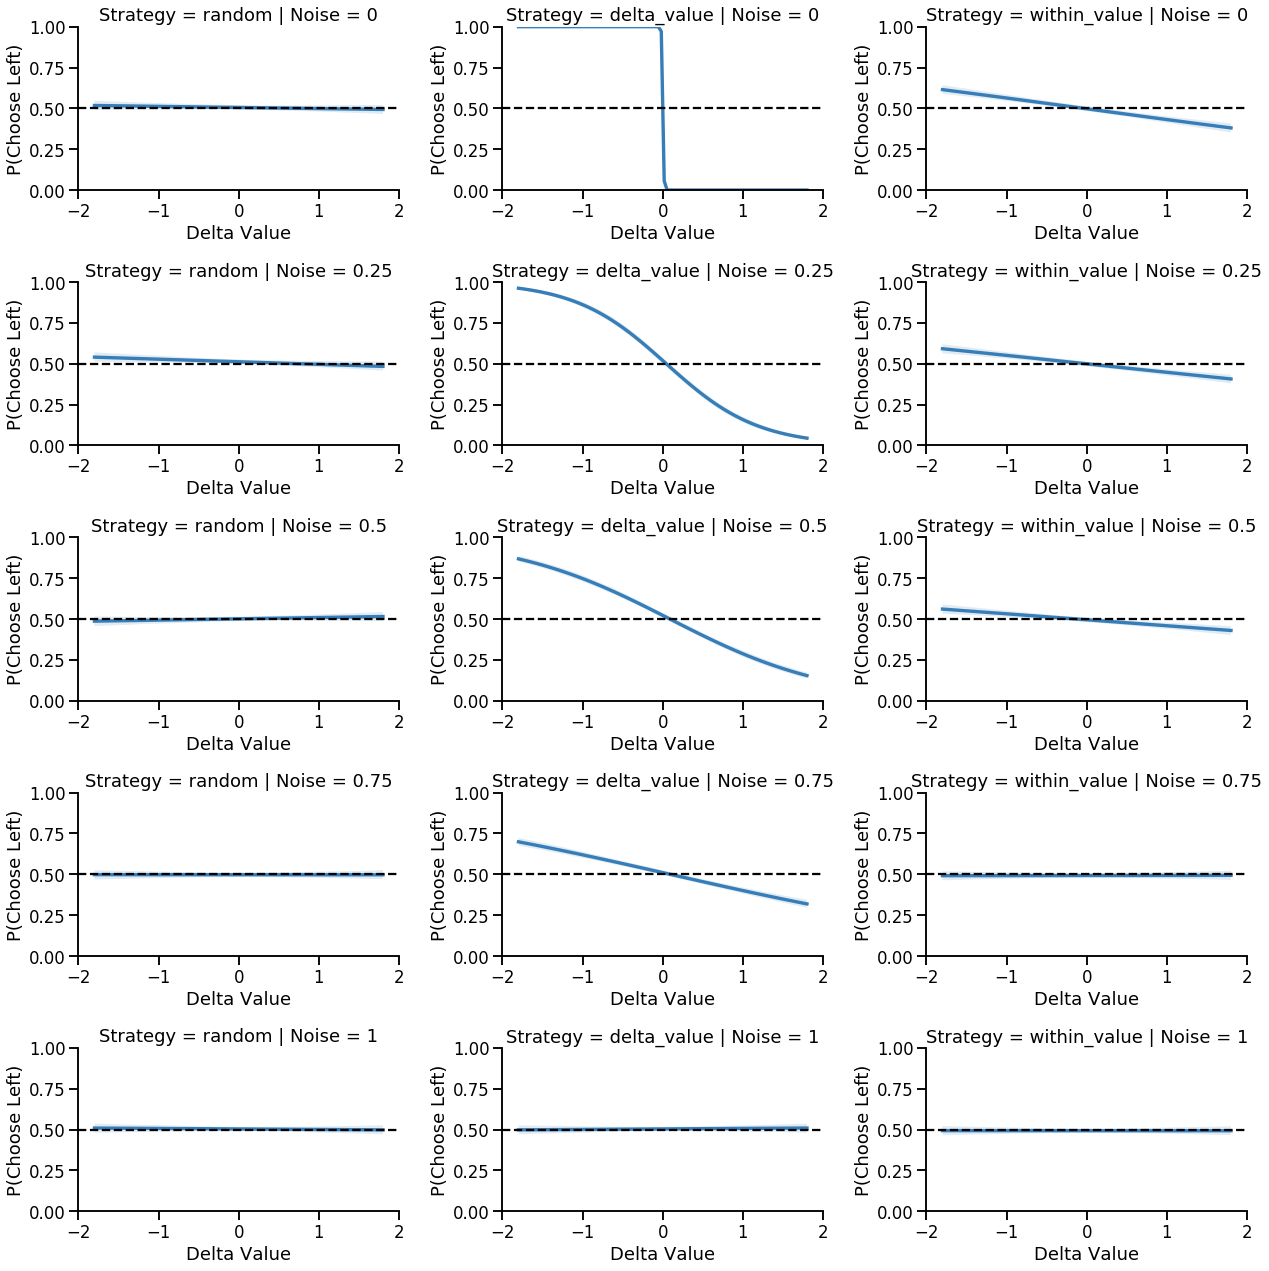

In [199]:
plotSimulations(x_axis="delta_value",
                x_label="Delta Value",
                x_scale=(-2,2))

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:880: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))


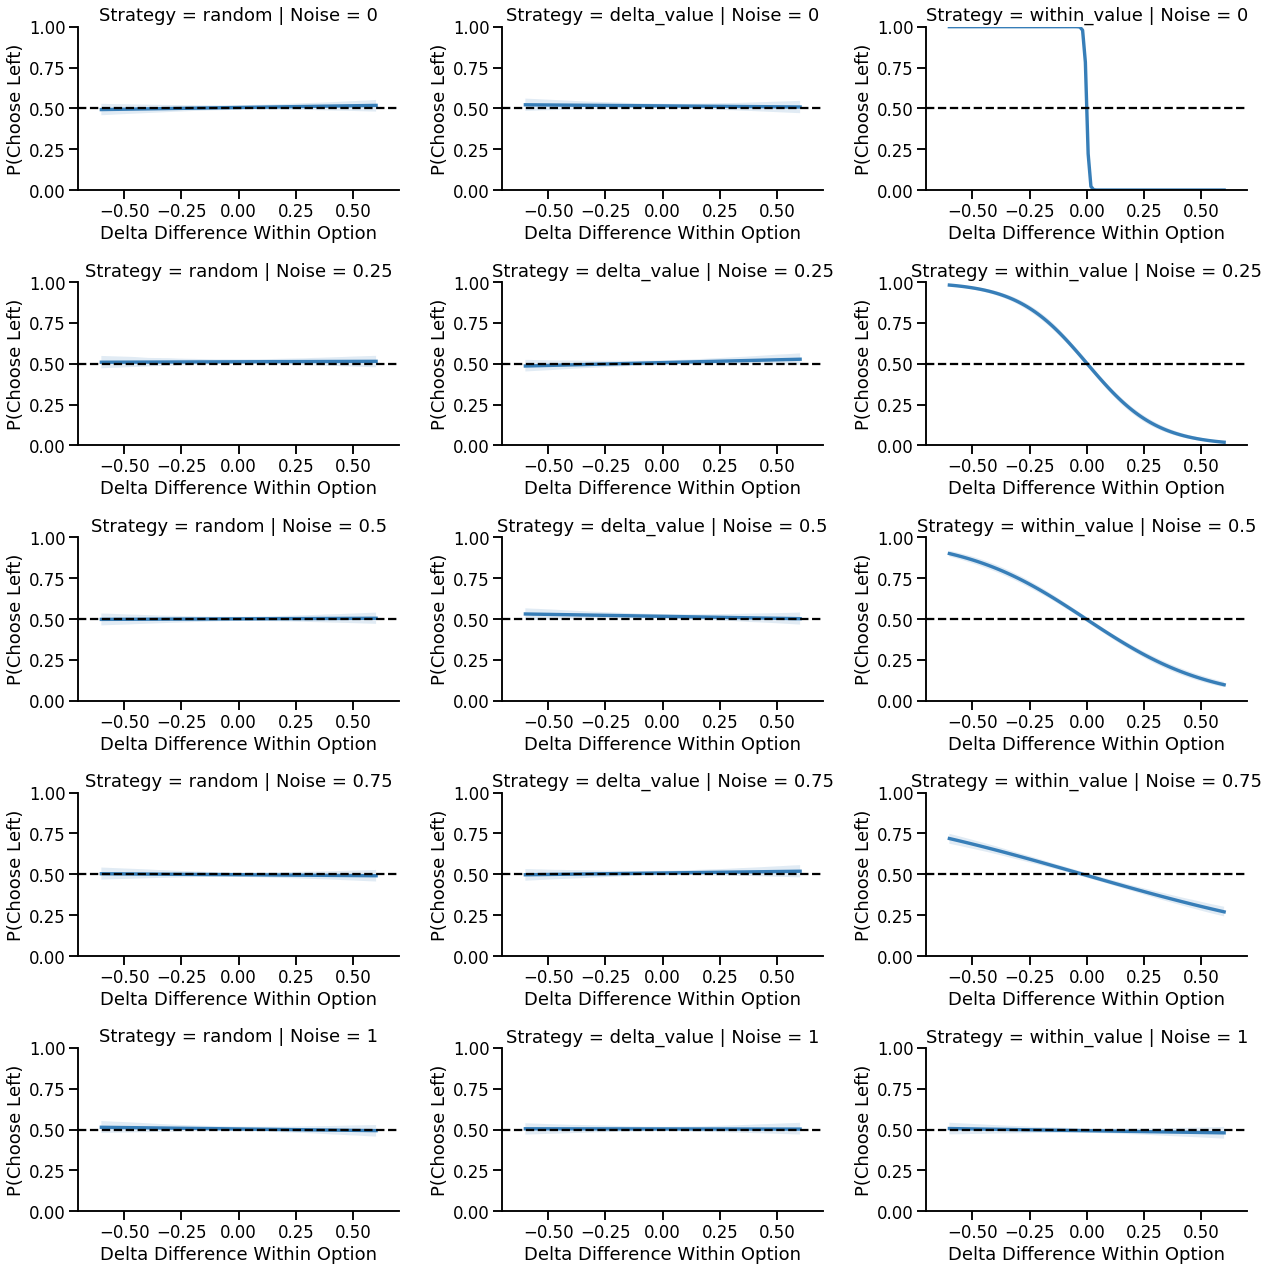

In [200]:
plotSimulations(x_axis="delta_within",
                x_label="Delta Difference Within Option",
                x_scale=(-0.7,0.7))

---
## Task Design
- Rest of notebook focuses on answering:

    - How many images do we need per level per category?
    - How uniformly distributed is delta value during the testing phase?

---
### How many images do we need to show?

In [210]:
test_n_imgs_shown = []
for option in ['face1','scene1','bodyp1','face2','scene2','bodyp2']:
    counts = sim_test_data.groupby(['sim_number',option]).size().reset_index(name="times_shown")
    counts['category'] = [option[:-1]] * len(counts)
    counts = counts.rename(columns={option:'level'})
    test_n_imgs_shown.append(counts)
test_n_imgs_shown = pd.concat(test_n_imgs_shown)
n_times_imgs_shown = test_n_imgs_shown.groupby(['sim_number','category','level']).times_shown.sum().reset_index(name='times_shown')
n_times_imgs_shown['times_shown']+=unique_images_per_level_learning

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


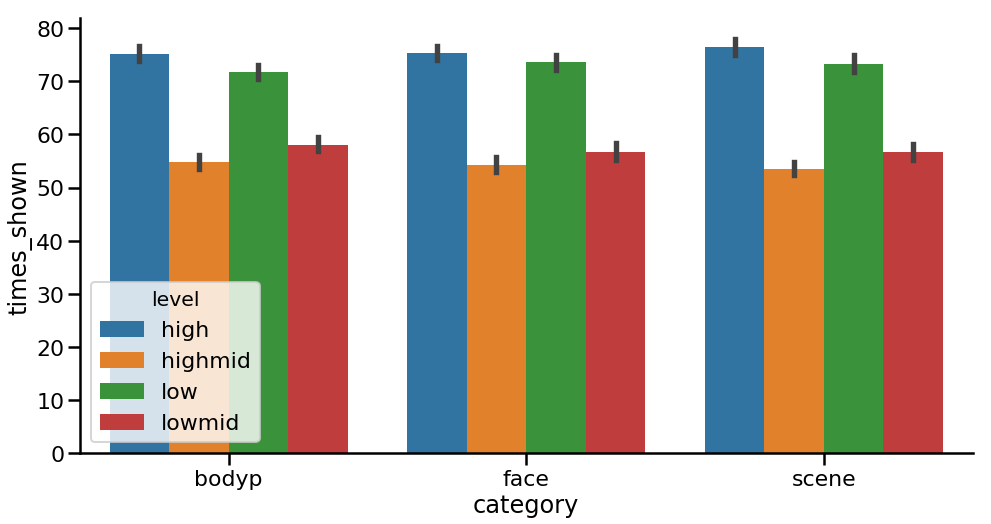

In [295]:
plt.subplots(1,1,figsize=(16,8))
sns.barplot(x="category",y="times_shown",hue="level",data=n_times_imgs_shown)
sns.despine();

---
### Verify that testing delta value is uniformly distributed

In [212]:
sim_test_trials.head()

,index,option1,option2,option1_value,option2_value,delta_value,sim_number
0,28,"(lowmid, highmid, highmid)","(highmid, low, low)",15,8,7,0
1,91,"(high, high, high)","(low, low, lowmid)",27,5,22,0
2,78,"(low, low, lowmid)","(high, highmid, high)",5,24,-19,0
3,81,"(high, high, highmid)","(low, low, low)",24,3,21,0
4,16,"(highmid, low, high)","(lowmid, low, high)",16,13,3,0


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


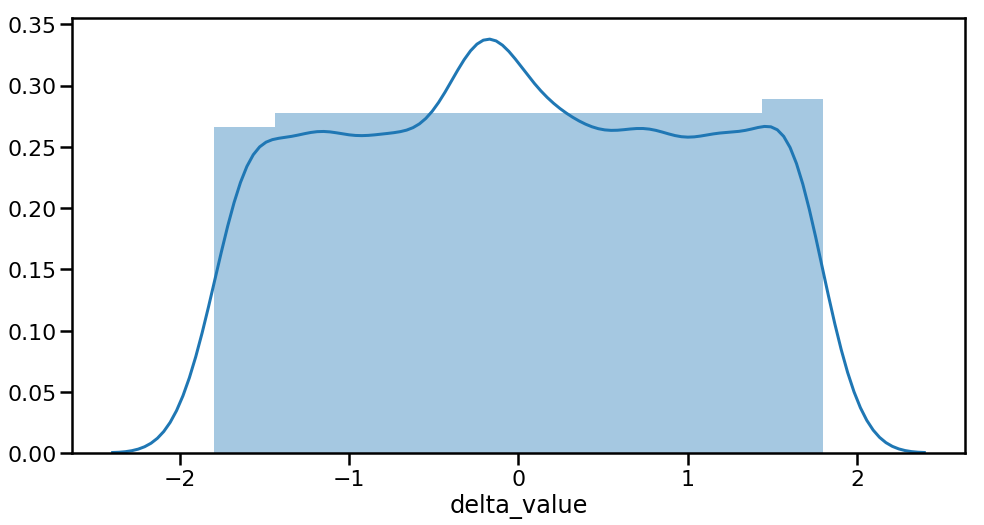

In [86]:
plt.subplots(1,1,figsize=(16,8))
sns.distplot(sim_test_trials['delta_value'],bins=10);

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


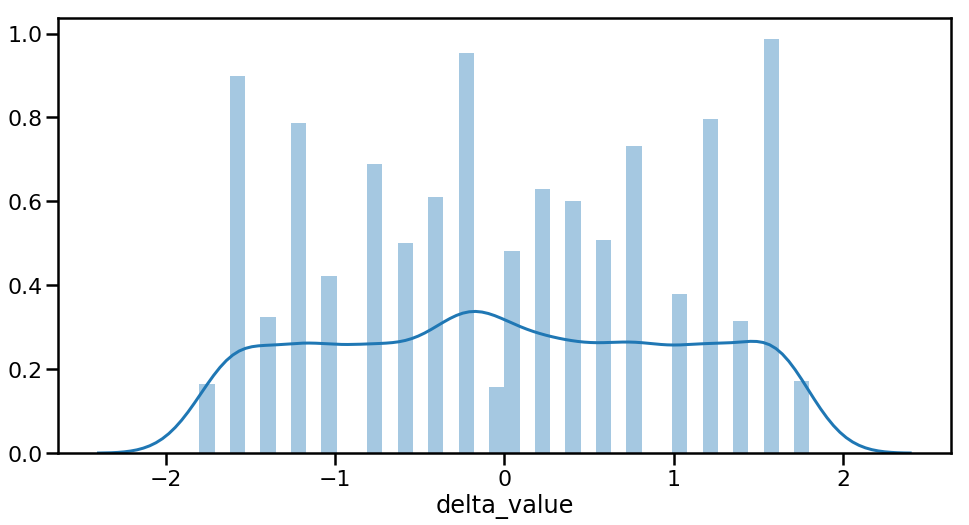

In [85]:
# what does our delta value distribution look like across all trials??
plt.subplots(1,1,figsize=(16,8))
sns.distplot(sim_test_trials['delta_value'],bins=40);

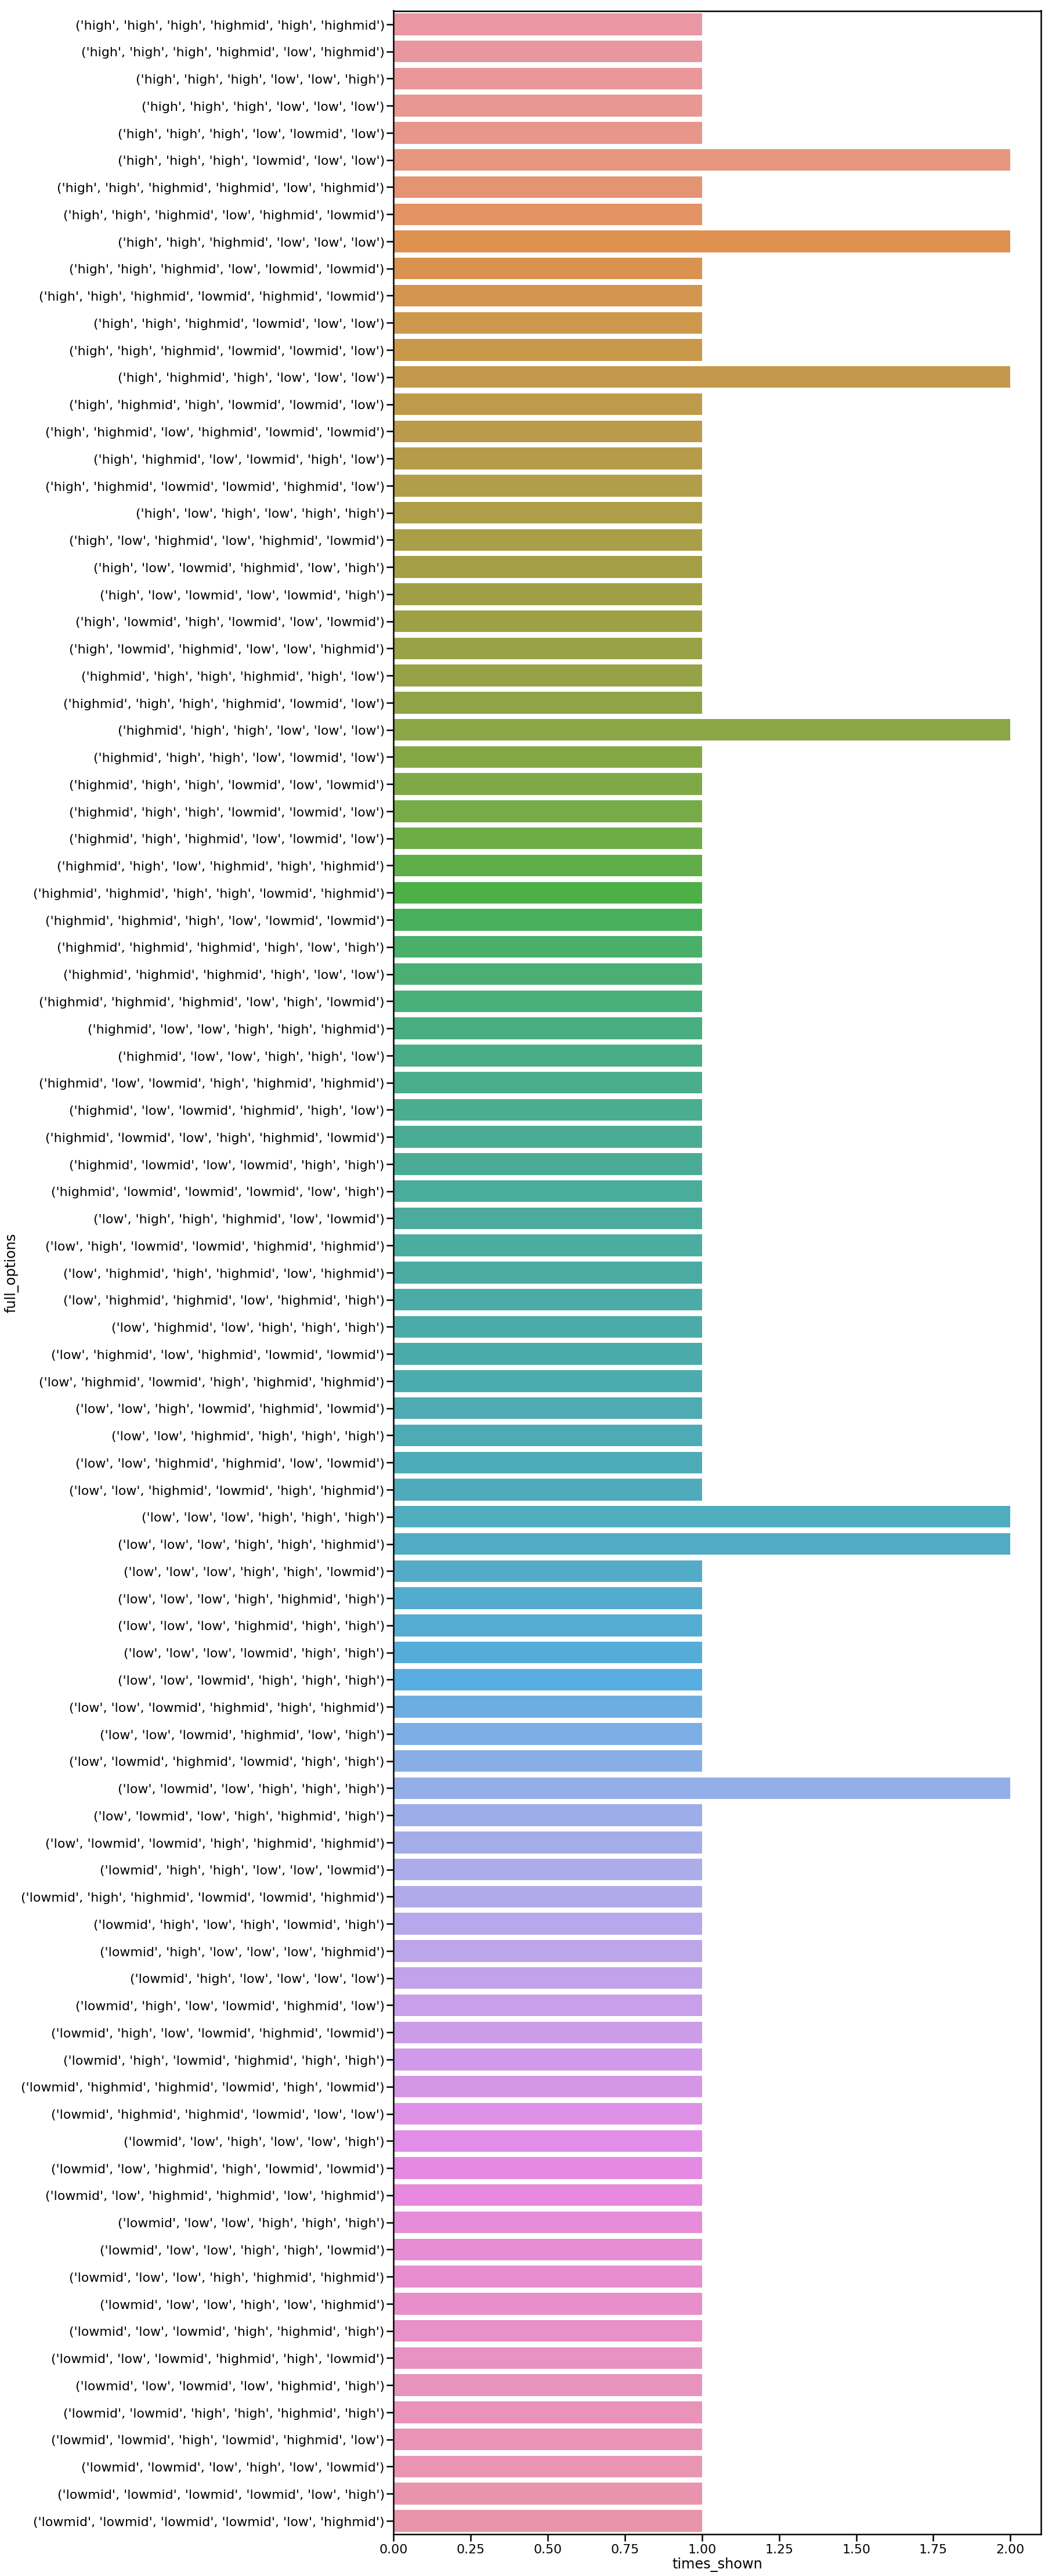

In [66]:
f, ax = plt.subplots(1,1,figsize=(20,80))
testing_combinations = sim_test_trials.groupby(['option1','option2']).size().reset_index(name="times_shown")
testing_combinations['full_options'] = testing_combinations['option1']+testing_combinations['option2']
sns.barplot(x="times_shown",y="full_options",data=testing_combinations)